In [ ]:
import os
import math
import numpy as np
import shutil
from roboflow import Roboflow


# ==== ROBOFLOW DATA DOWNLOAD ====
data_dir = "../data/Food-Ingredient-Recognition-1"

# Check if dataset already exists
if os.path.exists(data_dir):
    print(f"Dataset already exists at {data_dir}, skipping download.")
else:
    try:
        print("Downloading dataset from Roboflow...")
        rf = Roboflow(api_key="YOUR_API_KEY") 
        project = rf.workspace("test-image-preprocessing").project("food-ingredient-recognition-51ngf")
        dataset = project.version(1).download("coco", location="../data/")  # Download to ../data/ directory
        print(f"Dataset downloaded successfully to {data_dir}")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise


# ==== ORGANIZE FILES INTO CLASS DIRECTORIES ====
train_dir = '../data/Food-Ingredient-Recognition-1/train'
valid_dir = '../data/Food-Ingredient-Recognition-1/valid'
test_dir = '../data/Food-Ingredient-Recognition-1/test'

def organize_images_into_classes(base_dir):
    """Organize images into class subdirectories based on filename prefix before first number"""
    if not os.path.exists(base_dir):
        print(f"Directory not found: {base_dir}")
        return
    
    print(f"Organizing images in {base_dir}...")
    for filename in os.listdir(base_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Extract class name (before first number)
            class_name = ""
            for char in filename:
                if char.isdigit():
                    break
                class_name += char
            
            # Remove any trailing non-alphanumeric characters and convert to lowercase
            class_name = class_name.rstrip('_-. ').lower()
            
            if class_name:  # Only proceed if we found a valid class name
                class_dir = os.path.join(base_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)
                src = os.path.join(base_dir, filename)
                dst = os.path.join(class_dir, filename)
                
                # Only move if destination doesn't exist
                if not os.path.exists(dst):
                    shutil.move(src, dst)
            else:
                print(f"Warning: Could not extract class name from {filename}")

def filter_classes_by_count(base_dir, min_images=200):
    """Keep only classes with 200+ images, delete the rest"""
    if not os.path.exists(base_dir):
        print(f"Directory not found: {base_dir}")
        return []
    
    print(f"Filtering classes with less than {min_images} images...")
    valid_classes = []
    
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            # Count images in this class
            image_count = len([f for f in os.listdir(class_path) 
                             if f.endswith(('.jpg', '.jpeg', '.png'))])
            
            if image_count >= min_images:
                print(f"Keeping class '{class_name}' with {image_count} images")
                valid_classes.append(class_name)
            else:
                print(f"Removing class '{class_name}' with only {image_count} images")
                shutil.rmtree(class_path)
    
    return valid_classes

def match_classes_across_splits(valid_classes, train_dir, valid_dir, test_dir):
    """Ensure validation and test folders only contain classes that exist in train"""
    for split_dir, split_name in [(valid_dir, 'validation'), (test_dir, 'test')]:
        if not os.path.exists(split_dir):
            print(f"{split_name} directory not found: {split_dir}")
            continue
            
        print(f"Matching classes in {split_name} folder...")
        
        # First organize images into class folders if not already done
        organize_images_into_classes(split_dir)
        
        # Remove classes that don't exist in train
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                if class_name not in valid_classes:
                    print(f"Removing class '{class_name}' from {split_name} (not in train)")
                    shutil.rmtree(class_path)
                else:
                    image_count = len([f for f in os.listdir(class_path) 
                                     if f.endswith(('.jpg', '.jpeg', '.png'))])
                    print(f"Keeping class '{class_name}' in {split_name} with {image_count} images")

# Execute the organization process
try:
    if os.path.exists(train_dir):
        # Step 1: Organize train images into class folders
        organize_images_into_classes(train_dir)
        
        # Step 2: Filter classes with less than 200 images
        valid_classes = filter_classes_by_count(train_dir, min_images=200)
        
        # Step 3: Match validation and test folders to train classes
        match_classes_across_splits(valid_classes, train_dir, valid_dir, test_dir)
        
        print(f"\nOrganization complete! Final classes: {valid_classes}")
        print(f"Total classes kept: {len(valid_classes)}")
        
    else:
        print(f"Train directory not found at {train_dir}")
        if not os.path.exists(data_dir):
            print("Dataset directory doesn't exist. Please run the download section first.")
            
except Exception as e:
    print(f"Error during organization: {e}")
    raise

Dataset already exists at ../data/Food-Ingredient-Recognition-1, skipping download.
Organizing images in ../data/Food-Ingredient-Recognition-1/train...
Filtering classes with less than 200 images...
Keeping class 'apple' with 246 images
Keeping class 'asparagus' with 225 images
Keeping class 'avocado' with 243 images
Keeping class 'banana' with 207 images
Removing class 'bell_peppers' with only 195 images
Keeping class 'bitter_gourd' with 237 images
Keeping class 'bok_choy' with 213 images
Keeping class 'broccoli' with 252 images
Removing class 'cabbage' with only 192 images
Removing class 'carrot' with only 198 images
Keeping class 'cashew_nut' with 231 images
Keeping class 'cauliflower' with 216 images
Keeping class 'chayote' with 240 images
Keeping class 'chicken_breast' with 219 images
Keeping class 'chicken_thighs' with 219 images
Keeping class 'chicken_wings' with 243 images
Removing class 'chilli' with only 189 images
Removing class 'coconut' with only 189 images
Keeping class '

In [3]:
import tensorflow as tf

# Set the paths to your data
train_dir = "../data/Food-Ingredient-Recognition-1/train"
val_dir = "../data/Food-Ingredient-Recognition-1/valid"
test_dir = "../data/Food-Ingredient-Recognition-1/test"

# Set parameters
img_size = (224, 224)
batch_size = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 9834 files belonging to 44 classes.
Found 636 files belonging to 44 classes.
Found 417 files belonging to 44 classes.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

target_size = (224, 224)
batch_size = 32
epochs = 25
seed = 42

# Set the classification data directory
classification_data_dir = data_dir

# ==== IMPROVED DATA GENERATORS (NO AUGMENTATION) ====
# Since we have enough images per class, we'll skip aggressive augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    # No augmentation - clean training on sufficient data
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# ==== DATA GENERATORS FOR ALL SPLITS ====
train_generator = train_datagen.flow_from_directory(
    os.path.join(classification_data_dir, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(classification_data_dir, 'valid'),  # Use proper validation split
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(classification_data_dir, 'test'),   # Use proper test split
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Classes: {list(train_generator.class_indices.keys())}")

# ==== BACK TO MOBILENETV2 (Better for smaller datasets) ====
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Start with ALL layers frozen
base_model.trainable = False

# ==== SIMPLER CLASSIFIER HEAD ====
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Smaller dense layer
x = layers.Dropout(0.3)(x)  # Less aggressive dropout
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Found 9834 images belonging to 44 classes.
Found 636 images belonging to 44 classes.
Found 417 images belonging to 44 classes.
Number of classes: 44
Classes: ['apple', 'asparagus', 'avocado', 'banana', 'bitter_gourd', 'bok_choy', 'broccoli', 'cashew_nut', 'cauliflower', 'chayote', 'chicken_breast', 'chicken_thighs', 'chicken_wings', 'corn', 'crab', 'cucumber', 'egg', 'eggplant', 'grapes', 'lettuce', 'lobster_tails', 'mango', 'melon', 'orange', 'oysters', 'pawpaw', 'peanuts', 'peas', 'pineapple', 'pork_belly', 'potato', 'pumpkin', 'radishes', 'red_rice', 'salmon', 'sea_scallops', 'shrimp', 'strawberry', 'sweet_potato', 'tempeh', 'tofu', 'tomato', 'tuna', 'white_rice']


Class distribution:
apple: 246 samples (weight: 0.91)
asparagus: 225 samples (weight: 0.99)
avocado: 243 samples (weight: 0.92)
banana: 207 samples (weight: 1.08)
bitter_gourd: 237 samples (weight: 0.94)
bok_choy: 213 samples (weight: 1.05)
broccoli: 252 samples (weight: 0.89)
cashew_nut: 231 samples (weight: 0.97)
cauliflower: 216 samples (weight: 1.03)
chayote: 240 samples (weight: 0.93)
chicken_breast: 219 samples (weight: 1.02)
chicken_thighs: 219 samples (weight: 1.02)
chicken_wings: 243 samples (weight: 0.92)
corn: 204 samples (weight: 1.10)
crab: 231 samples (weight: 0.97)
cucumber: 219 samples (weight: 1.02)
egg: 231 samples (weight: 0.97)
eggplant: 201 samples (weight: 1.11)
grapes: 207 samples (weight: 1.08)
lettuce: 210 samples (weight: 1.06)
lobster_tails: 237 samples (weight: 0.94)
mango: 219 samples (weight: 1.02)
melon: 207 samples (weight: 1.08)
orange: 234 samples (weight: 0.96)
oysters: 240 samples (weight: 0.93)
pawpaw: 231 samples (weight: 0.97)
peanuts: 222 samples

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 150s 475ms/step - accuracy: 0.3685 - loss: 2.9555 - val_accuracy: 0.8286 - val_loss: 1.5052 - learning_rate: 0.0010
Epoch 2/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 93s 302ms/step - accuracy: 0.7826 - loss: 1.6431 - val_accuracy: 0.8396 - val_loss: 1.4223 - learning_rate: 0.0010
Epoch 3/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 96s 311ms/step - accuracy: 0.8516 - loss: 1.4580 - val_accuracy: 0.8648 - val_loss: 1.3647 - learning_rate: 0.0010
Epoch 4/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 97s 315ms/step - accuracy: 0.8878 - loss: 1.3586 - val_accuracy: 0.8695 - val_loss: 1.3380 - learning_rate: 0.0010
Epoch 5/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 92s 298ms/step - accuracy: 0.9026 - loss: 1.3145 - val_accuracy: 0.8695 - val_loss: 1.3525 - learning_rate: 0.0010
Epoch 6/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 93s 301ms/step - accuracy: 0.9226 - loss: 1.2636 - val_accuracy: 0.8648 - val_loss: 1.3580 - learning_rate: 0.0010
Epoch 7/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 93s 300ms/step - accuracy: 0.

Model saved successfully!

FINAL EVALUATION
Validation Accuracy: 0.8836 (88.36%)
Validation Loss: 1.2537
Test Accuracy: 0.8753 (87.53%)
Test Loss: 1.2596

Selected 44 balanced classes:
Classes: ['apple', 'asparagus', 'avocado', 'banana', 'bitter_gourd', 'bok_choy', 'broccoli', 'cashew_nut', 'cauliflower', 'chayote', 'chicken_breast', 'chicken_thighs', 'chicken_wings', 'corn', 'crab', 'cucumber', 'egg', 'eggplant', 'grapes', 'lettuce', 'lobster_tails', 'mango', 'melon', 'orange', 'oysters', 'pawpaw', 'peanuts', 'peas', 'pineapple', 'pork_belly', 'potato', 'pumpkin', 'radishes', 'red_rice', 'salmon', 'sea_scallops', 'shrimp', 'strawberry', 'sweet_potato', 'tempeh', 'tofu', 'tomato', 'tuna', 'white_rice']

Data Distribution:
Training samples: 9834
Validation samples: 636
Test samples: 417
Total samples: 10887


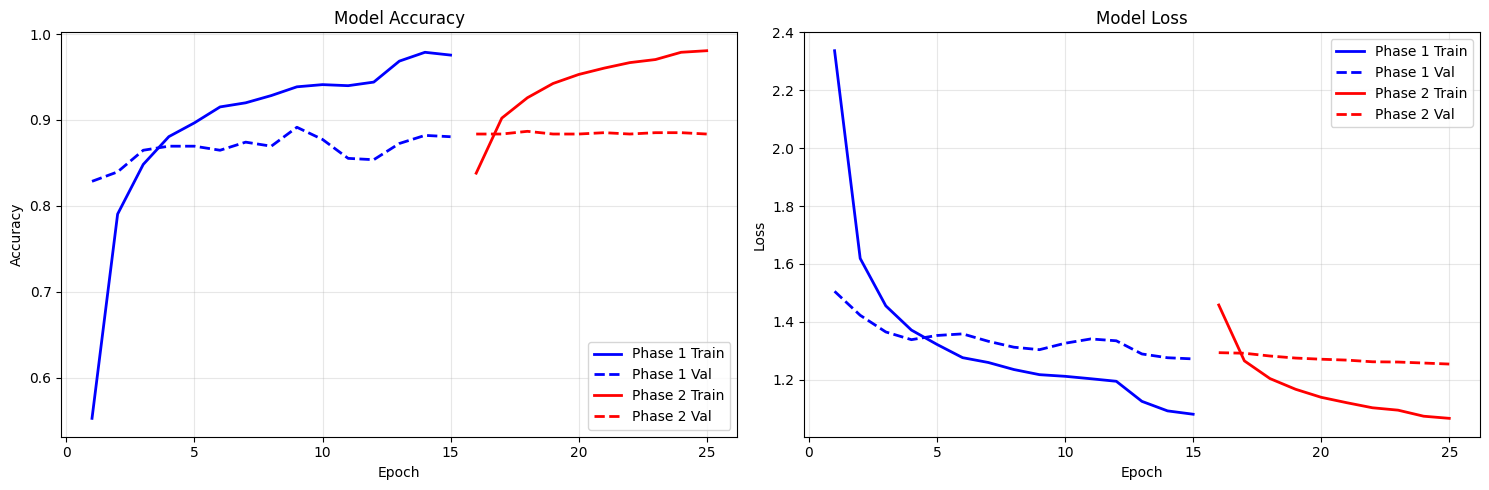

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# ==== COMPILE ====
model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Higher learning rate for frozen base
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ==== CALLBACKS ====
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # More patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

# ==== CLASS WEIGHTS ====
# Get unique classes that actually exist in the data
unique_classes = np.unique(train_generator.classes)
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=train_generator.classes
)

# Create class weights dictionary mapping actual class indices to weights
class_weights = {}
for i, class_idx in enumerate(unique_classes):
    class_weights[class_idx] = class_weights_array[i]

print("Class distribution:")
for class_name, class_idx in train_generator.class_indices.items():
    count = np.sum(train_generator.classes == class_idx)
    weight = class_weights.get(class_idx, 1.0)  # Default weight if missing
    print(f"{class_name}: {count} samples (weight: {weight:.2f})")

# Debug info
print(f"\nDebug info:")
print(f"Total samples: {len(train_generator.classes)}")
print(f"Unique class indices in data: {sorted(unique_classes)}")
print(f"Class indices from generator: {sorted(train_generator.class_indices.values())}")
print(f"Number of class folders found: {len(train_generator.class_indices)}")

# ==== PHASE 1: TRAIN WITH FROZEN BASE ====
print("\n=== PHASE 1: Training with frozen base ===")
history1 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / batch_size),
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / batch_size),
    epochs=15,  # Fewer epochs for phase 1
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# ==== PHASE 2: FINE-TUNE TOP LAYERS (OPTIONAL) ====
print("\n=== PHASE 2: Fine-tuning top layers ===")
# Unfreeze only the top layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keep most layers frozen
    layer.trainable = False

# Lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Much lower learning rate
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / batch_size),
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / batch_size),
    epochs=10,  # Fewer epochs for fine-tuning
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)



# ==== EVALUATION ON TEST SET ====
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Validation set performance
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Validation Loss: {val_loss:.4f}")

# Test set performance (final unseen data)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Get the selected classes from the training generator
selected_classes = list(train_generator.class_indices.keys())
print(f"\nSelected {len(selected_classes)} balanced classes:")
print(f"Classes: {selected_classes}")

# Data distribution summary
print(f"\nData Distribution:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Total samples: {train_generator.samples + val_generator.samples + test_generator.samples}")

# ==== TRAINING HISTORY VISUALIZATION (Optional) ====
import matplotlib.pyplot as plt

def plot_training_history(history1, history2=None):
    """Plot training history for both phases"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Combine histories if phase 2 exists
    if history2 is not None:
        # Phase 1
        epochs1 = range(1, len(history1.history['accuracy']) + 1)
        # Phase 2 (continue from where phase 1 ended)
        epochs2 = range(len(history1.history['accuracy']) + 1, 
                       len(history1.history['accuracy']) + len(history2.history['accuracy']) + 1)
        
        # Plot accuracy
        ax1.plot(epochs1, history1.history['accuracy'], 'b-', label='Phase 1 Train', linewidth=2)
        ax1.plot(epochs1, history1.history['val_accuracy'], 'b--', label='Phase 1 Val', linewidth=2)
        ax1.plot(epochs2, history2.history['accuracy'], 'r-', label='Phase 2 Train', linewidth=2)
        ax1.plot(epochs2, history2.history['val_accuracy'], 'r--', label='Phase 2 Val', linewidth=2)
        
        # Plot loss
        ax2.plot(epochs1, history1.history['loss'], 'b-', label='Phase 1 Train', linewidth=2)
        ax2.plot(epochs1, history1.history['val_loss'], 'b--', label='Phase 1 Val', linewidth=2)
        ax2.plot(epochs2, history2.history['loss'], 'r-', label='Phase 2 Train', linewidth=2)
        ax2.plot(epochs2, history2.history['val_loss'], 'r--', label='Phase 2 Val', linewidth=2)
    else:
        # Only phase 1
        epochs = range(1, len(history1.history['accuracy']) + 1)
        ax1.plot(epochs, history1.history['accuracy'], 'b-', label='Train', linewidth=2)
        ax1.plot(epochs, history1.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
        ax2.plot(epochs, history1.history['loss'], 'b-', label='Train', linewidth=2)
        ax2.plot(epochs, history1.history['val_loss'], 'r-', label='Validation', linewidth=2)
    
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the training history
try:
    plot_training_history(history1, history2)
except Exception as e:
    print(f"Could not plot training history: {e}")
    print("Training completed successfully without visualization.")

In [11]:
import json

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model
model.save('../models/food_knower.h5')
print("Model saved successfully!")

# Save class indices to a JSON file
with open('../models/class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f, indent=2)

Model saved successfully!


In [10]:
from tensorflow.keras.preprocessing import image



def predict_image(model, img_path, class_names):
    """
    Predict food ingredient from image
    
    Args:
        model: Trained keras model
        img_path: Path to image file
        class_names: List of class names
    
    Returns:
        predicted_class: String of predicted class
        confidence: Float confidence score
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]
    
    predicted_class = class_names[predicted_idx]
    
    return predicted_class, confidence

class_names = list(train_generator.class_indices.keys())
predicted_class, confidence = predict_image(model, '../data/Food-Ingredient-Recognition-1/manual_test/white_rice.png', class_names)
print(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")






Predicted: white_rice (Confidence: 0.93)
